In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Layer # Import the Layer class
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#sampleRNASeq = pd.read_csv('ESA_Sample.csv', index_col=0)

In [ ]:
import numpy as np
import pandas as pd

def generate_synthetic_data(num_samples=14, num_genes=100, num_tissues=3, num_methylation_sites=50, include_tissue_column=True):
    """
    Generate synthetic control and treated datasets for methylation and expression profiles with tissue-specific differences.

    Args:
    - num_samples (int): Number of samples per tissue.
    - num_genes (int): Number of genes for the expression dataset.
    - num_tissues (int): Number of distinct tissue types.
    - num_methylation_sites (int): Number of methylation sites for the methylation dataset.
    - include_tissue_column (bool): Whether to include a tissue column to differentiate tissue types.

    Returns:
    - control_data (DataFrame): Combined control dataset (expression + methylation + tissue).
    - treated_data (DataFrame): Combined treated dataset (expression + methylation + tissue).
    """

    # Initialize lists for data collection
    control_data_list = []
    treated_data_list = []

    # Generate tissue-specific profiles
    tissue_names = [f'Tissue_{i+1}' for i in range(num_tissues)]

    for tissue_idx, tissue_name in enumerate(tissue_names):
        # Generate baseline control expression and methylation profiles
        control_expression = np.random.normal(loc=10 + tissue_idx * 2, scale=1.0, size=(num_samples, num_genes))  # baseline expression
        control_methylation = np.random.normal(loc=0.5 + tissue_idx * 0.05, scale=0.1, size=(num_samples, num_methylation_sites))  # baseline methylation

        # Generate treated expression and methylation profiles (introduce shift from control)
        treated_expression = control_expression + np.random.normal(loc=2.0, scale=1.5, size=(num_samples, num_genes))  # treatment shift
        treated_methylation = control_methylation + np.random.normal(loc=0.1, scale=0.05, size=(num_samples, num_methylation_sites))  # treatment shift

        # Create a tissue label column if needed
        if include_tissue_column:
            tissue_column = np.full((num_samples, 1), tissue_name)
            control_expression = np.hstack([control_expression, tissue_column])
            treated_expression = np.hstack([treated_expression, tissue_column])
            control_methylation = np.hstack([control_methylation, tissue_column])
            treated_methylation = np.hstack([treated_methylation, tissue_column])

        # Create DataFrames for easier handling
        control_expression_df = pd.DataFrame(control_expression, columns=[f'Gene_{i+1}' for i in range(num_genes)] + (['Tissue'] if include_tissue_column else []))
        control_methylation_df = pd.DataFrame(control_methylation, columns=[f'Meth_Site_{i+1}' for i in range(num_methylation_sites)] + (['Tissue'] if include_tissue_column else []))
        treated_expression_df = pd.DataFrame(treated_expression, columns=[f'Gene_{i+1}' for i in range(num_genes)] + (['Tissue'] if include_tissue_column else []))
        treated_methylation_df = pd.DataFrame(treated_methylation, columns=[f'Meth_Site_{i+1}' for i in range(num_methylation_sites)] + (['Tissue'] if include_tissue_column else []))

        # Combine expression and methylation data for each condition (control/treated)
        control_combined_df = pd.concat([control_expression_df, control_methylation_df], axis=1)
        treated_combined_df = pd.concat([treated_expression_df, treated_methylation_df], axis=1)

        # Append the data to the lists
        control_data_list.append(control_combined_df)
        treated_data_list.append(treated_combined_df)

    # Combine all tissue data
    control_data = pd.concat(control_data_list, axis=0).reset_index(drop=True)
    treated_data = pd.concat(treated_data_list, axis=0).reset_index(drop=True)

    return control_data, treated_data




In [ ]:
# Example usage:
control_data, treated_data = generate_synthetic_data(num_samples=50000, num_genes=1000, num_tissues=3, num_methylation_sites=1000, include_tissue_column=True)

# Print a sample of the generated datasets
control_data.head()

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Meth_Site_992,Meth_Site_993,Meth_Site_994,Meth_Site_995,Meth_Site_996,Meth_Site_997,Meth_Site_998,Meth_Site_999,Meth_Site_1000,Tissue
0,9.372726027490842,9.415105711872023,11.838649241901923,8.940651365058336,9.671071338876734,11.335622356318282,8.675293564041892,10.035889838467812,9.773988115720268,9.802751243784797,...,0.5678014090190263,0.4887845836721807,0.607859534058774,0.532829315040152,0.7390035088040632,0.5525719862405515,0.5312245298498685,0.5355592461066502,0.3758178560879086,Tissue_1
1,12.143915341131601,9.29469108044962,8.820643564317782,11.554340612307053,9.873422296982396,8.869889967834773,10.315287346767988,7.491872261359953,10.896595016982058,8.746728460593742,...,0.48281781759594905,0.4511426535920168,0.5633982985675743,0.4345872546315475,0.5660022723698901,0.2546468181381486,0.4517444093374392,0.5641941209224954,0.45017639676750787,Tissue_1
2,11.630296017343085,8.75365394584554,8.967049114373308,10.976213281069775,11.425696555253392,11.380631535418152,10.923640959352591,9.709056899911872,10.00822895148827,7.721855269321763,...,0.2686870196648963,0.6742873384507139,0.40645853578558716,0.4038735548822308,0.44917062374623945,0.8060318786428127,0.5692013099873678,0.2644615515533564,0.49169282129055414,Tissue_1
3,10.542906181103197,9.225645385349685,10.400710081951074,10.23828770949221,10.221231353415284,9.309907961750834,7.490915579284786,9.23296239739656,8.868933075134255,11.593304139207463,...,0.512952604332443,0.545709210196845,0.3620418293909907,0.3735724546926539,0.5402929106547488,0.5694719645857884,0.6263359442233232,0.5845248216251442,0.4645999337474964,Tissue_1
4,8.319463868506833,10.173133280641578,9.844422312259502,11.318942222026786,8.302577369767782,10.74621865668992,10.385825831344597,10.151360298881274,9.965605458625474,9.229549455297477,...,0.5028423847955202,0.40773272280591993,0.5420208319657541,0.41967495482079287,0.44014816546941216,0.47878616737354823,0.43497419077697014,0.3938711396808689,0.47683632880578775,Tissue_1


In [ ]:
treated_data.head( 1)

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Meth_Site_992,Meth_Site_993,Meth_Site_994,Meth_Site_995,Meth_Site_996,Meth_Site_997,Meth_Site_998,Meth_Site_999,Meth_Site_1000,Tissue
0,10.522271314647243,11.58376109262169,15.060110656296166,14.409863171589912,12.098532249137936,11.874711629127592,12.185423822285662,13.780163914860642,13.449660200076885,12.458425136384372,...,0.6524459648930964,0.631119700558543,0.6372848050078946,0.5656420610634735,0.9085384682007602,0.6348209841019601,0.6915959564467062,0.6334907625305833,0.5037465441072936,Tissue_1


In [ ]:
# prompt: remove the last column and save it as a new variable

tissue_column_control = control_data['Tissue']
control_data = control_data.drop('Tissue', axis=1)

tissue_column_treated = treated_data['Tissue']
treated_data = treated_data.drop('Tissue', axis=1)


In [ ]:
treated_data.head(2)

,Gene_1,Gene_2,Gene_3,Gene_4,Gene_5,Gene_6,Gene_7,Gene_8,Gene_9,Gene_10,...,Meth_Site_991,Meth_Site_992,Meth_Site_993,Meth_Site_994,Meth_Site_995,Meth_Site_996,Meth_Site_997,Meth_Site_998,Meth_Site_999,Meth_Site_1000
0,10.522271314647243,11.58376109262169,15.060110656296166,14.409863171589912,12.098532249137936,11.874711629127592,12.185423822285662,13.780163914860642,13.449660200076885,12.458425136384372,...,0.49884714938858554,0.6524459648930964,0.631119700558543,0.6372848050078946,0.5656420610634735,0.9085384682007602,0.6348209841019601,0.6915959564467062,0.6334907625305833,0.5037465441072936
1,13.43833718272261,8.739251061879054,9.654352085610428,13.905188479442572,11.764900960063496,10.552097596948638,12.259455681536869,12.016961421198237,11.664273984689427,11.623969618286363,...,0.6635712361943907,0.6246606834511836,0.5577847868934454,0.6655995022874847,0.5522424517752045,0.6494657200425986,0.36427452743475075,0.5641505442241104,0.6787597901464292,0.5241735480237255


In [ ]:
control_data.shape

(150000, 2000)

In [ ]:

!pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.9 MB/s eta 0:00:00


In [ ]:
my_sample_groups = control_data.index

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


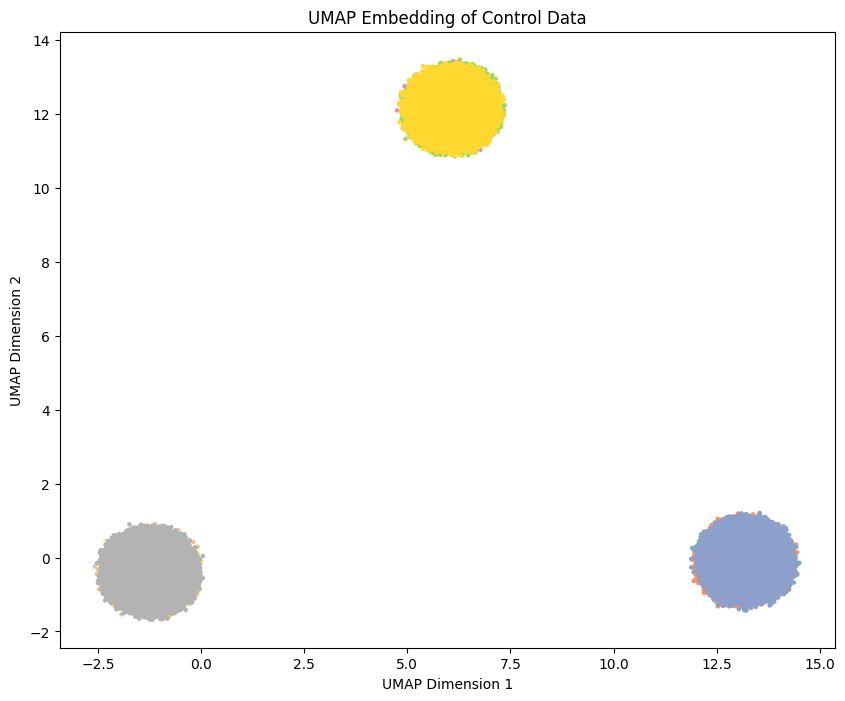

In [ ]:
# prompt: generate a UMAP for control  data alone. color by mapping each row index to its corresponding index in my_sample_groups

import umap
import matplotlib.pyplot as plt

# Assuming 'control_data' is your dataframe and 'my_sample_groups' is your list of group labels

# Create a UMAP reducer
reducer = umap.UMAP()

# Fit and transform your data to the reduced dimensions
embedding = reducer.fit_transform(control_data)

# Create a dictionary mapping sample group index to its corresponding color
group_colors = {group_index: i for i, group_index in enumerate(control_data.index)}
# Get a list of colors for each row based on the mapping
row_colors = [group_colors[index] for index in control_data.index]


# Plot the UMAP embedding, colored by sample group
plt.figure(figsize=(10, 8))
plt.scatter(embedding[:, 0], embedding[:, 1], c=row_colors, cmap='Set2', s=5)
plt.title('UMAP Embedding of Control Data')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


In [ ]:
preExp = control_data
postExp = treated_data

In [ ]:
#re-arrange data

#ctrl = np.array(preExp.transpose())
#expo = np.array(postExp.transpose())

In [ ]:
#standardize data

scaler_exp = StandardScaler()

X_expression = scaler_exp.fit_transform(preExp)
Y_expression = scaler_exp.fit_transform(postExp)

In [ ]:
#join expression and methylation
X = np.concatenate([X_expression], axis=1)
Y = np.concatenate([Y_expression], axis=1)


In [ ]:
# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)


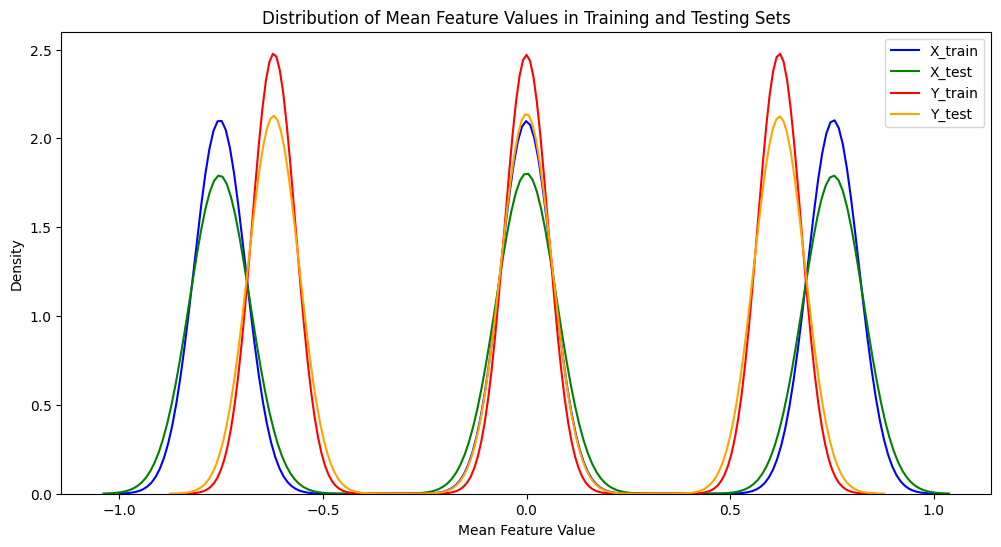

In [ ]:
# prompt: plot the distribution of x_train, x_test, y_train and y_test, use a KDE plot and let the curves overlap with different colors

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Plot KDE for X_train
sns.kdeplot(X_train.mean(axis=1), label='X_train', color='blue')

# Plot KDE for X_test
sns.kdeplot(X_test.mean(axis=1), label='X_test', color='green')

# Plot KDE for Y_train
sns.kdeplot(Y_train.mean(axis=1), label='Y_train', color='red')

# Plot KDE for Y_test
sns.kdeplot(Y_test.mean(axis=1), label='Y_test', color='orange')

plt.xlabel('Mean Feature Value')
plt.ylabel('Density')
plt.title('Distribution of Mean Feature Values in Training and Testing Sets')
plt.legend()
plt.show()


In [ ]:
# 2. Building the VAE
input_dim = X.shape[1]
output_dim = Y.shape[1]
latent_dim = 100


# Encoder
input_layer = layers.Input(shape=(input_dim,), name='control_input')
x = layers.Dense(256, activation='relu')(input_layer)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)




In [ ]:
# Sampling
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


In [ ]:
# Decoder
decoder_input = layers.Input(shape=(latent_dim,), name='z_sampling')
x_decoded = layers.Dense(128, activation='relu')(decoder_input)
x_decoded = layers.Dense(256, activation='relu')(x_decoded)
output_layer = layers.Dense(output_dim, activation='linear', name='treated_output')(x_decoded)

decoder = models.Model(decoder_input, output_layer, name='decoder')


In [ ]:
# VAE Model
treated_output = decoder(z)
vae = models.Model(input_layer, treated_output, name='VAE')


# Loss
#tf.keras.losses.CategoricalCrossentropy()

class MyLayer(Layer):
    def call(self, inputs):

      y_true, y_pred = inputs
      reconstruction_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
      # Calculate the mean within the call method
      return  tf.reduce_mean(reconstruction_loss) * output_dim


#x = MyLayer()(x)


#reconstruction_loss = MyLayer()([Y_train, treated_output])
#reconstruction_loss = tf.reduce_mean(reconstruction_loss) * output_dim

def reconstruction_loss_fn(y_true, y_pred):
  return MyLayer()([y_true, y_pred])



class KLLossLayer(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        return kl_loss

def kl_loss_fn(z_mean, z_log_var):
  return KLLossLayer()([z_mean, z_log_var])


# vae_loss = reconstruction_loss + kl_loss
# vae.add_loss(vae_loss)
# Define separate input layers for the loss function
z_mean_input = layers.Input(shape=(latent_dim,), name='z_mean_input')
z_log_var_input = layers.Input(shape=(latent_dim,), name='z_log_var_input')

# Include the KL loss as a separate output of the model
# Give a name to the outputs in the model definition
vae = models.Model(inputs=[input_layer, z_mean_input, z_log_var_input],
                  outputs=[treated_output, KLLossLayer()([z_mean_input, z_log_var_input])], # Remove the dictionary from outputs
                  name='VAE')

vae.compile(optimizer='adam',
            loss = [reconstruction_loss_fn, lambda y_true, y_pred: y_pred], # Remove the dictionary from loss and reference the functions directly
            loss_weights=[1.0, 1.0]) # Remove the dictionary from loss_weights

vae.summary()

Model: "VAE"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 control_input (InputLayer)  [(None, 2000)]               0         []                            
                                                                                                  
 dense (Dense)               (None, 256)                  512256    ['control_input[0][0]']       
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 z_mean (Dense)              (None, 100)                  12900     ['dense_1[0][0]']             
                                                                                                

In [ ]:
encoder = models.Model(input_layer, [z_mean, z_log_var], name='encoder') # z_mean and z_log_var are KerasTensors

# 3. Training
# Calculate z_mean and z_log_var for the training data
z_mean_train, z_log_var_train = encoder.predict(X_train)

# Calculate z_mean and z_log_var for the test data
z_mean_test, z_log_var_test = encoder.predict(X_test)


#engineer early stoping

early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = vae.fit([X_train, z_mean_train, z_log_var_train], [Y_train, np.zeros((X_train.shape[0], 1))], # Pass the correct input data for all three input layers and a dummy output for the KL loss.
                  epochs=100,
                  batch_size=1000,
                  validation_data=([X_test, z_mean_test, z_log_var_test], [Y_test, np.zeros((X_test.shape[0], 1))]),
                  callbacks=[early_stopping]) # Pass the correct input data for all three input layers for validation and a dummy output for the KL loss.

1407/1407 [==============================] - 3s 2ms/step
Epoch 1/100
105/105 [==============================] - 7s 48ms/step - loss: -3317210.0000 - decoder_loss: -3317210.7500 - kl_loss_layer_loss: 0.5543 - val_loss: -4507831.5000 - val_decoder_loss: -4507832.0000 - val_kl_loss_layer_loss: 0.5537
Epoch 2/100
105/105 [==============================] - 3s 28ms/step - loss: -4509361.5000 - decoder_loss: -4509362.0000 - kl_loss_layer_loss: 0.5543 - val_loss: -4212570.5000 - val_decoder_loss: -4212571.0000 - val_kl_loss_layer_loss: 0.5537
Epoch 3/100
105/105 [==============================] - 3s 28ms/step - loss: -5279850.0000 - decoder_loss: -5279850.0000 - kl_loss_layer_loss: 0.5543 - val_loss: -5506680.5000 - val_decoder_loss: -5506681.5000 - val_kl_loss_layer_loss: 0.5537
Epoch 4/100
105/105 [==============================] - 3s 29ms/step - loss: -5642230.0000 - decoder_loss: -5642231.5000 - kl_loss_layer_loss: 0.5543 - val_loss: -5766254.5000 - val_decoder_loss: -5766254.5000 - val_kl

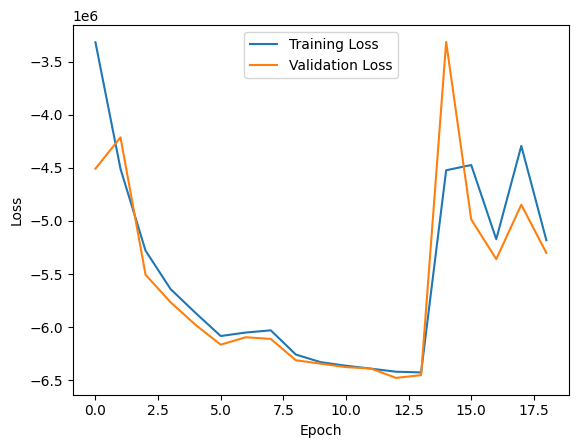

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Calculate z_mean and z_log_var for the input data
z_mean, z_log_var = encoder.predict(X)

# Make predictions using the calculated values
Y_pred = vae.predict([X, z_mean, z_log_var])

4688/4688 [==============================] - 13s 3ms/step


<Axes: >

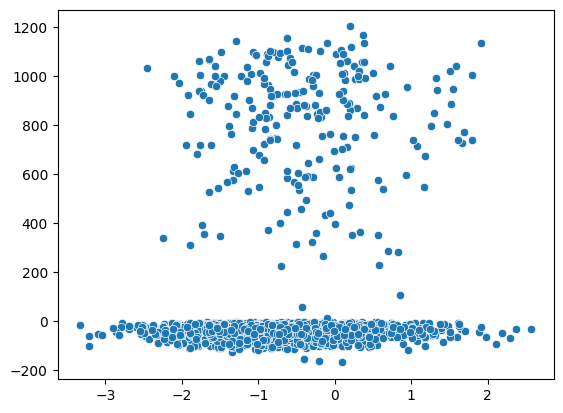

In [ ]:
sns.scatterplot(  x= Y[1], y = Y_pred[0][1])
#

<Axes: ylabel='Density'>

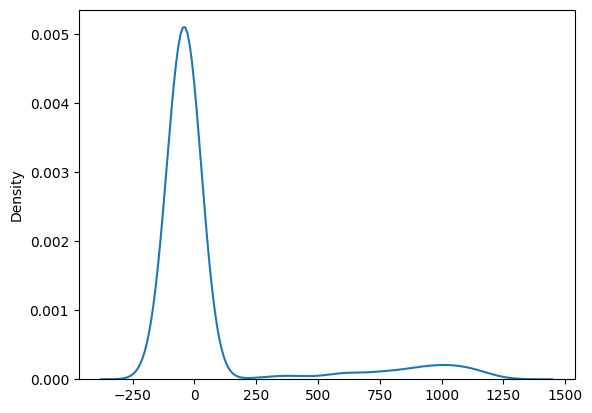

In [ ]:
sns.kdeplot(Y_pred[0][0])